# PixelCNN

**Author** Luis Leal

Implementation of PixelCNN from the paper [Pixel Recurrent Neural Networks](https://arxiv.org/pdf/1601.06759.pdf) from Google DeepMind

Autoregressive model to generate images pixel by pixel conditionally: every pixel probability is condition on previous pixels.
<img src="pixelCNNfig2.png">

It generates images one pixel at a time conditioned on all pixels before it following the chain/product rule of probability, the probability of an image X is:

<img src="pixelcnnequation1.png">

Every pixel is modeled as a discrete random variable with 256 possible values [0,255] and the model ouputs the PMF/distribution using a softmax activation

<img src="pixelCNNdist.png">

Based on: https://github.com/jzbontar/pixelcnn-pytorch/blob/master/main.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split

from tqdm import tqdm
import math

In [2]:
BATCH_SIZE = 256
LAYERS = 8
KERNEL_SIZE = 7
INPUT_CHANNELS = 1 #black and white
IMAGE_SIZE = 28 # image size is assumed square
CHANNELS = 64 #channels of hidden layers
EPOCHS = 30


NUM_PLOT_PICTURES = 10
SAVE_PATH = "./pixelCNNmodel.pth"
DEVICE = torch.device("cuda:0")

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

train_set = torchvision.datasets.MNIST("./data",train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=BATCH_SIZE,shuffle=True)

## Plotting and sampling

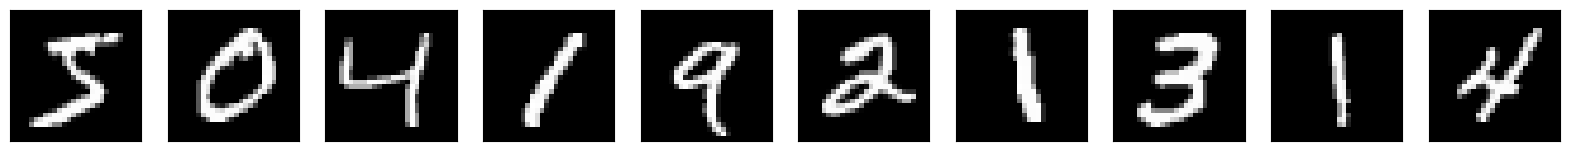

In [4]:
plt.figure(figsize=(20,5))

for i in range(NUM_PLOT_PICTURES):
    img = train_set[i][0]
    ax = plt.subplot(1, NUM_PLOT_PICTURES, i+1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    plt.imshow(img.cpu().squeeze().numpy(), cmap="gist_gray")
    
plt.show()

In [5]:
def sample(model):
    model.eval()
    # create dummy tensor to store generated images pixel by pixel
    sample = torch.Tensor(NUM_PLOT_PICTURES,INPUT_CHANNELS,IMAGE_SIZE,IMAGE_SIZE).to(DEVICE)
    sample.fill_(0)
    
    # generate images pixel by pixel
    for i in range(IMAGE_SIZE):
        for j in range(IMAGE_SIZE):
            # calculate the probability distribution for current pixel
            # applying the softmax to the last dimmension of the tensor
            # and then sample a pixel value based on that distribution
            # to finally normalize to [0,1] range
            output = model(sample)
            output_prob = F.softmax(output[:,:,i,j],dim=-1).data
            
            sample[:,:,i,j] = torch.multinomial(output_prob,1).float()/255
            
    # plot results
    plt.figure(figsize=(10,10))
    
    for i in range(NUM_PLOT_PICTURES):
        ax = plt.subplot(1, NUM_PLOT_PICTURES,i+1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(transforms.ToPILImage()(sample[i,:,:,:]),
                  interpolation="bicubic", cmap="gist_gray"
                  )
        
    plt.show()

## Architecture

The model uses a special convolution layer called "masked convolution" the idea is to create a mask so during training no "future" pixels are seen setting 0s to future pixels(it masks gradients too) because training and prediction are different: while training we have the whole images, but during prediction the image is generated one pixel at a time with no access to future pixels.

In [6]:
class MaskedConv2d(nn.Conv2d):
    
    def __init__(self, mask_type, *args, **kwargs):
        """mask_type is A or B, different mask for different layers(from the paper)
           the first layer has a mask type A
        """
        self.mask_type = mask_type
        super(MaskedConv2d, self).__init__(*args,**kwargs)
        
        # creates a buffer copy of the weights data called mask
        # this has the same data but different memory location
        # tensor of size batch_size x channels x height x width
        self.register_buffer("mask", self.weight.data.clone())
        self.mask.fill_(1)
        
        _, depth, height, width = self.weight.size()
        
        
        if mask_type == "A":
            self.mask[:,:,height//2,width//2:] = 0
            self.mask[:,:,height//2+1:,:] = 0
        else:
            self.mask[:,:,height//2,width//2+1:] = 0
            self.mask[:,:,height//2+1:,:] = 0
            
    def forward(self,x):
        # first apply the mask to the weights then forward as a common conv2d
        self.weight.data*= self.mask
        return super(MaskedConv2d,self).forward(x)

In [7]:
class PixelCNN(nn.Module):
    def __init__(self,num_layers=8,kernel_size=7,channels=64,device=None):
        super(PixelCNN,self).__init__()
        self.num_layers = num_layers
        self.kernel_size = kernel_size
        self.channels = channels
        self.layers = {}
        self.device = device
        
        """
        Create first mask(type A),1 input channel(black and white images),
        use kernel size parameter, strides of 1 and padding of kernel//2
        """
        self.MaskAConv = nn.Sequential(
            MaskedConv2d("A",1,channels,kernel_size,1,kernel_size//2,bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(True)
        )
        
        # create the rest of masks(type B)
        MaskBConvs = []
        for i in range(num_layers):
            MaskBConvs.append(MaskedConv2d("B",channels,channels, kernel_size,1, kernel_size//2, bias=False))
            MaskBConvs.append(nn.BatchNorm2d(channels))
            MaskBConvs.append(nn.ReLU(True))
            
        self.MaskBConvs = nn.Sequential(*MaskBConvs)
        
        """the output uses channels input channels, 256 outputs for softmax the pixel values, 1 kernel size"""
        self.output = nn.Conv2d(channels,256,1)
        
        
    def forward(self,x):
        x = self.MaskAConv(x)
        x = self.MaskBConvs(x)
        
        return self.output(x)
    
    

In [8]:
model = PixelCNN().to(DEVICE)
print(model)

PixelCNN(
  (MaskAConv): Sequential(
    (0): MaskedConv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (MaskBConvs): Sequential(
    (0): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)

## Optimization

In [9]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
loss_function = nn.CrossEntropyLoss()

## Training

Epoch: 1/30, loss:1.044: : 235it [00:57,  4.06it/s]                             


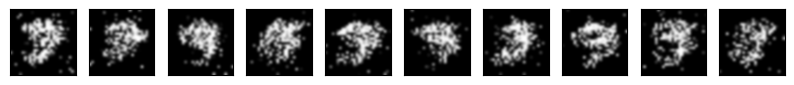

Epoch: 2/30, loss:0.783: : 235it [00:58,  4.01it/s]                             


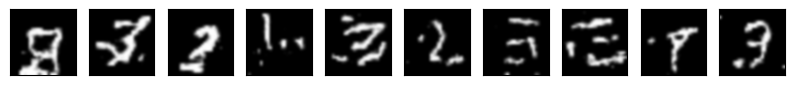

Epoch: 3/30, loss:0.770: : 235it [00:58,  4.00it/s]                             


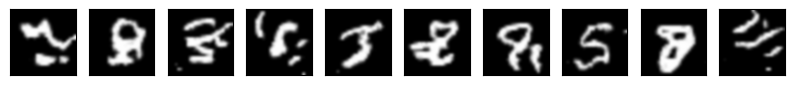

Epoch: 4/30, loss:0.731: : 235it [00:57,  4.05it/s]                             


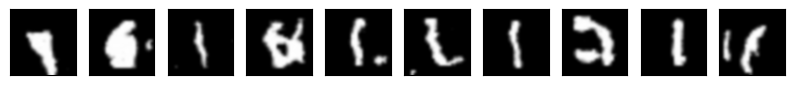

Epoch: 5/30, loss:0.773: : 235it [00:58,  4.04it/s]                             


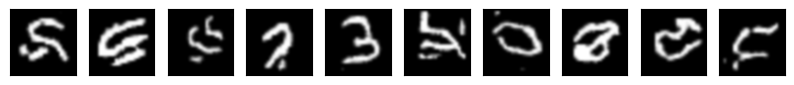

Epoch: 6/30, loss:0.739: : 235it [00:58,  4.03it/s]                             


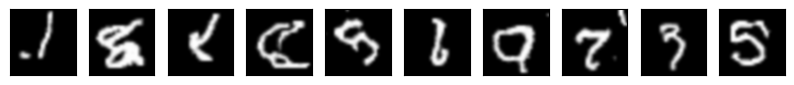

Epoch: 7/30, loss:0.743: : 235it [00:58,  4.05it/s]                             


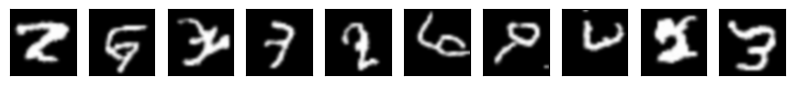

Epoch: 8/30, loss:0.734: : 235it [00:58,  4.00it/s]                             


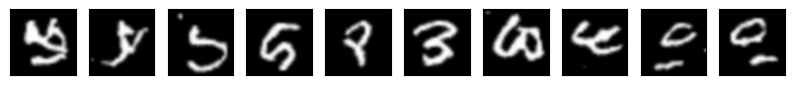

Epoch: 9/30, loss:0.749: : 235it [00:58,  4.03it/s]                             


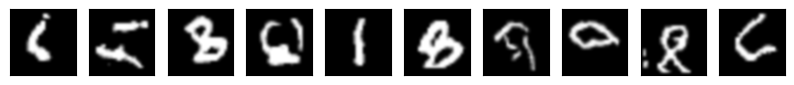

Epoch: 10/30, loss:0.732: : 235it [00:58,  4.04it/s]                            


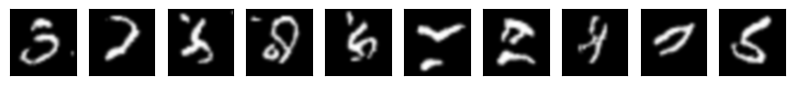

Epoch: 11/30, loss:0.704: : 235it [00:58,  3.99it/s]                            


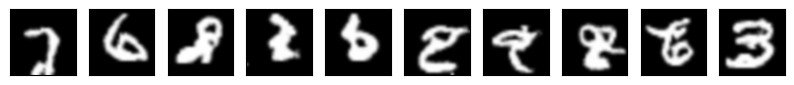

Epoch: 12/30, loss:0.703: : 235it [00:58,  4.04it/s]                            


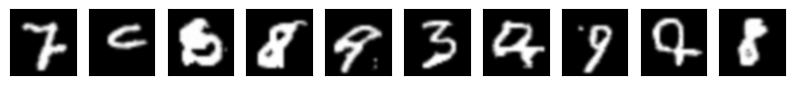

Epoch: 13/30, loss:0.709: : 235it [00:58,  4.02it/s]                            


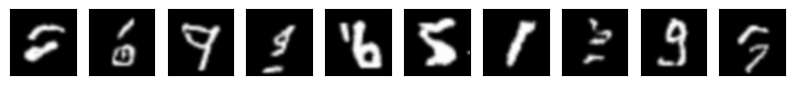

Epoch: 14/30, loss:0.716: : 235it [00:58,  4.05it/s]                            


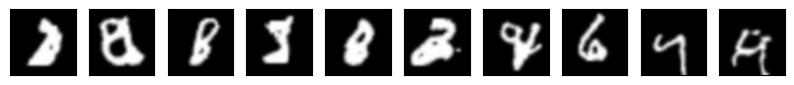

Epoch: 15/30, loss:0.695: : 235it [00:58,  4.03it/s]                            


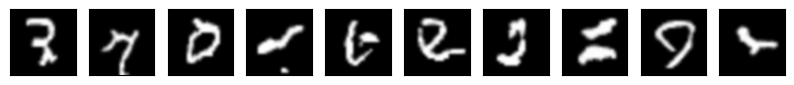

Epoch: 16/30, loss:0.691: : 235it [00:58,  4.00it/s]                            


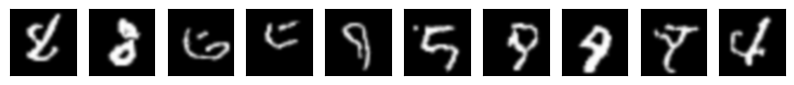

Epoch: 17/30, loss:0.709: : 235it [00:58,  4.02it/s]                            


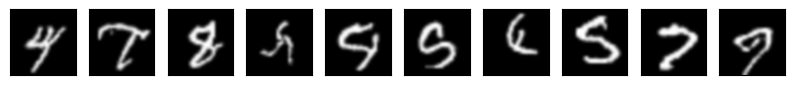

Epoch: 18/30, loss:0.693: : 235it [00:58,  4.03it/s]                            


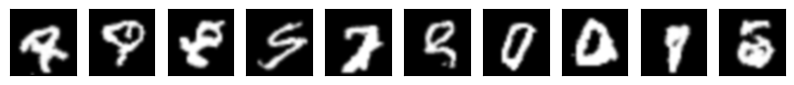

Epoch: 19/30, loss:0.655: : 235it [00:58,  4.05it/s]                            


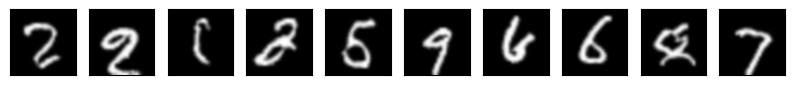

Epoch: 20/30, loss:0.715: : 235it [00:58,  4.01it/s]                            


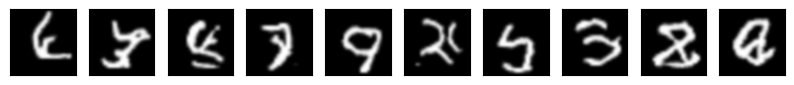

Epoch: 21/30, loss:0.720: : 235it [00:58,  4.03it/s]                            


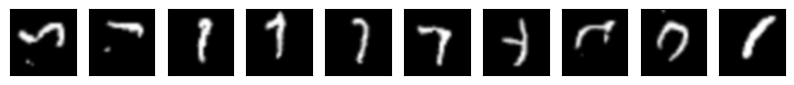

Epoch: 22/30, loss:0.637: : 235it [00:58,  4.02it/s]                            


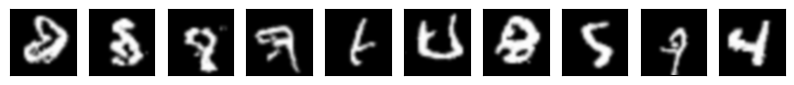

Epoch: 23/30, loss:0.663: : 235it [00:58,  4.02it/s]                            


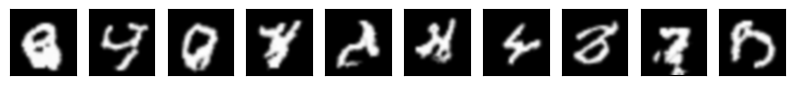

Epoch: 24/30, loss:0.660: : 235it [00:58,  4.00it/s]                            


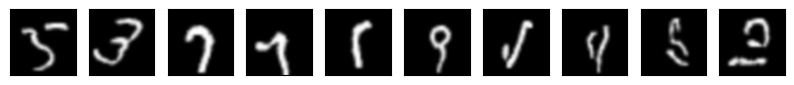

Epoch: 25/30, loss:0.670: : 235it [00:58,  4.01it/s]                            


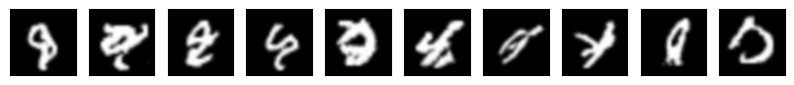

Epoch: 26/30, loss:0.667: : 235it [00:58,  4.02it/s]                            


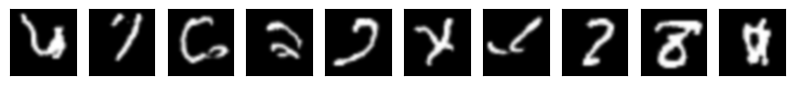

Epoch: 27/30, loss:0.658: : 235it [00:57,  4.05it/s]                            


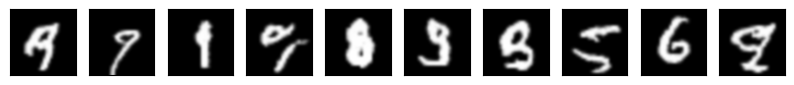

Epoch: 28/30, loss:0.652: : 235it [00:58,  4.02it/s]                            


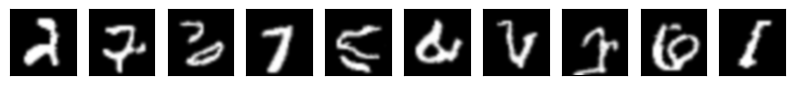

Epoch: 29/30, loss:0.628: : 235it [00:58,  4.03it/s]                            


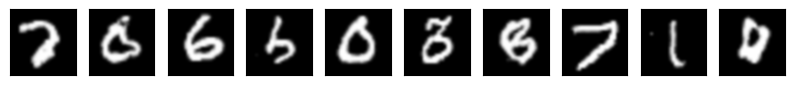

Epoch: 30/30, loss:0.652: : 235it [00:58,  4.02it/s]                            


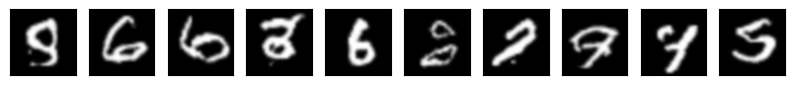

In [10]:
losses = []
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(enumerate(train_loader,0),total=int(len(train_set)/train_loader.batch_size))
    
    for idx,data in progress_bar:
        X,Y = data
        
        # get first channel and transform from [0,1] to [0,255] range
        target = (X[:,0,:,:] * 255).long()
        
        X = X.to(DEVICE)
        target = target.to(DEVICE)
        
        # forward and backpropagation and parameter update
        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_function(outputs,target)
        loss.backward()
        optimizer.step()
        
        # metrics
        losses.append(loss.item())
        running_loss += loss.item()
        progress_bar.set_description(f"Epoch: {epoch +1}/{EPOCHS}, loss:{loss.item():.3f}")
    sample(model)
    
torch.save(model.state_dict(),SAVE_PATH)

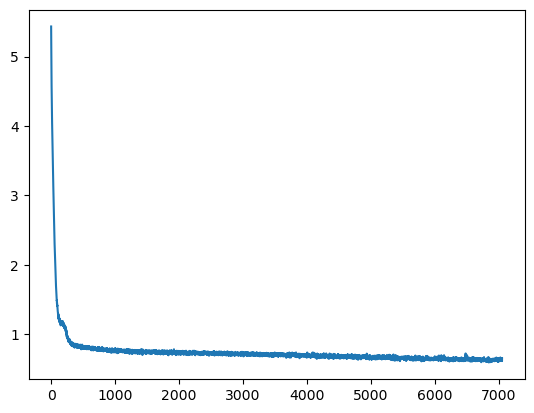

In [12]:
plt.plot(losses)
plt.show()